In [ ]:
!pip3 install matplotlib

In [6]:
import os
import sys
import time
import json

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import CLIPProcessor, CLIPModel
# import clip 
import clip

In [99]:
device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training
print("Model loaded successfully")


Model loaded successfully


In [8]:
# run this cell to annotate images manually

path = "/Users/sunnyjay/Documents/vscode/AI Security Server V2/clip_finetuning/Training_Data"
class annotation_helper():
    def __init__(self, path):
        self.path = path
        self.images = os.listdir(path)
        self.annotations = {}
        # make annotations.json if it doesn't exist
        if not os.path.exists(f'{path}/annotations.json'):
            with open(f'{path}/annotations.json', 'w') as fp:
                json.dump({}, fp)

    def save_annotations(self):
        # save annotations as json file
        with open(f'{path}/annotations.json', 'w') as fp:
            json.dump(self.annotations, fp)
            print("Annotations saved!")
    def user_annotate(self):
        for image in self.images:
            self.annotations = json.load(open(f'{path}/annotations.json'))
            if image in self.annotations:
                continue
            # open image notebook
            im = Image.open(os.path.join(path, image))
            plt.imshow(im)
            plt.show()
            # get user input
            annotation = input("Enter annotation: ")
            # get rid of the image after annotation
            plt.close()
            # save annotation
            self.annotations[image] = annotation
            # save annotations
            self.save_annotations()

annotation_helper = annotation_helper(path)
annotation_helper.user_annotate()


UnidentifiedImageError: cannot identify image file '/Users/sunnyjay/Documents/vscode/AI Security Server V2/clip_finetuning/Training_Data/annotations.json'

In [100]:
class image_title_dataset(Dataset):
    def __init__(self,data_path):

        json_path = f'{data_path}/annotations.json'
        with open(json_path) as json_file:
            data = json.load(json_file)

        images = list(data.keys())
        annotations = [data[image] for image in images]

        self.image_path = [os.path.join(data_path, image) for image in images]
        self.title  = clip.tokenize(annotations) #you can tokenize everything at once in here(slow at the beginning), or tokenize it in the training loop.

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        image = preprocess(Image.open(self.image_path[idx])) # Image from PIL module
        title = self.title[idx]
        return image,title

In [ ]:
# prepare model, dataset, and data loader
device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training
model.eval()
print("Model loaded successfully")


BATCH_SIZE = 3
EPOCH = 10

dataset=image_title_dataset("/Users/sunnyjay/Documents/vscode/AI Security Server V2/clip_finetuning/Training_Data")
print(len(dataset))
for image, title in dataset:
    print(image.shape)
    print(title.shape)
    break
train_dataloader = DataLoader(dataset,batch_size = BATCH_SIZE,shuffle=True)

In [122]:
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 


if device == "cpu":
  model.float()
else :
  clip.model.convert_weights(model) # Actually this line is unnecessary since clip by default already on float16

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

# for fine tuning clip, the optimizer is extremely sensitive to the hyperparams. most configurations cause sever overfitting.
optimizer = optim.Adam(model.parameters(), lr=1e-8,betas=(0.9,0.98),eps=1e-6,weight_decay=0.001) 

# add your own code to track the training progress.
for epoch in range(EPOCH):
    print(f"Starting epoch {epoch+1}/{EPOCH}...")
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        images, texts = batch

        images = images.to(device)
        texts = texts.to(device)

        logits_per_image, logits_per_text = model(images, texts)

        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)

        total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
        total_loss.backward()
        if device == "cpu":
            optimizer.step()
        else: 
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)
        
        if i % 2 == 0:  # print every 10 batches
            print(f"  Batch {i}: Loss = {total_loss.item()}")
    print(f"Finished epoch {epoch+1}/{EPOCH}")

print("Training finished, saving model...")
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': total_loss,
    }, f"/Users/sunnyjay/Documents/vscode/AI Security Server V2/clip_finetuning/Output_Models/model_10.pt") #just change to your preferred folder/filename

Model loaded successfully
12
torch.Size([3, 224, 224])
torch.Size([77])
Starting epoch 1/10...
  Batch 0: Loss = 1.2384397983551025
  Batch 2: Loss = 2.6176416873931885
Finished epoch 1/10
Starting epoch 2/10...
  Batch 0: Loss = 1.2271395921707153
  Batch 2: Loss = 0.9161645174026489
Finished epoch 2/10
Starting epoch 3/10...
  Batch 0: Loss = 1.4118363857269287
  Batch 2: Loss = 1.500736951828003
Finished epoch 3/10
Starting epoch 4/10...
  Batch 0: Loss = 1.021026372909546
  Batch 2: Loss = 2.0585505962371826
Finished epoch 4/10
Starting epoch 5/10...
  Batch 0: Loss = 1.1193479299545288
  Batch 2: Loss = 1.1205984354019165
Finished epoch 5/10
Starting epoch 6/10...
  Batch 0: Loss = 1.3858340978622437
  Batch 2: Loss = 1.9825586080551147
Finished epoch 6/10
Starting epoch 7/10...
  Batch 0: Loss = 2.3029489517211914
  Batch 2: Loss = 1.4012068510055542
Finished epoch 7/10
Starting epoch 8/10...
  Batch 0: Loss = 1.9031140804290771
  Batch 2: Loss = 1.6082372665405273
Finished epoch

Base Model Prediction:
amazon delivery driver with package : 73.73%
front door           : 0.00%
UPS delivery driver with package : 26.27%
univorn              : 0.00%
Fine Tuned Model Prediction:
amazon delivery driver with package : 73.80%
front door           : 0.00%
UPS delivery driver with package : 26.20%
univorn              : 0.00%


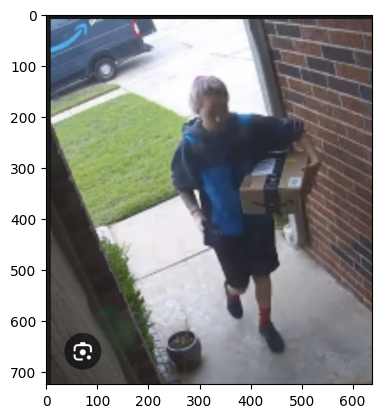

In [139]:
# compare fine tuned model against base model on an unseen image
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training
checkpoint = torch.load("/Users/sunnyjay/Documents/vscode/AI Security Server V2/clip_finetuning/Output_Models/model_10.pt") #just change to your preferred folder/filename


model.load_state_dict(checkpoint['model_state_dict'])

# run inference

img = "/Users/sunnyjay/Documents/vscode/AI Security Server V2/clip_finetuning/test3.png"
# show image


image = preprocess(Image.open(img)).unsqueeze(0).to(device)
classes = ["amazon delivery driver with package",
            "front door",
            "UPS delivery driver with package",
            'univorn']
text = clip.tokenize(classes).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

base_model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training

# run inference again
with torch.no_grad():
    image_features = base_model.encode_image(image)
    text_features = base_model.encode_text(text)
    
    logits_per_image, logits_per_text = base_model(image, text)
    probs2 = logits_per_image.softmax(dim=-1).cpu().numpy()




print('Base Model Prediction:')
for i in zip(classes, probs2[0]):
    print(f'{i[0]:20s} : {i[1]*100:.2f}%')

print('Fine Tuned Model Prediction:')
for i in zip(classes, probs[0]):
    print(f'{i[0]:20s} : {i[1]*100:.2f}%')

im = Image.open(img)
plt.imshow(im)

# the fine tuned model is more confident in its prediction of amazon driver


In [29]:
a = [9.9571109e-01 ,7.3395495e-04, 3.5106717e-03 ,4.4303903e-05]

# print as clean numbers
for i in probs[0]:
    print("{:.5f}".format(i))

0.17113
0.81854
0.01033
